In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pywt import wavedec
from scipy.signal import find_peaks
from scipy.stats import median_absolute_deviation
from sklearn.linear_model import lars_path

from Scripts.debiasing import debiasing_int, debiasing
from Scripts.fista_update import fista_update as fista
from Scripts.hrf_matrix import HRFMatrix
from Scripts.temporal_ta import filter_boundary as ta_filter
from Scripts.total_activation import total_activation as ta
from Scripts.total_activation import hrf_filters
from Scripts.simulate import fMRIsim
from Scripts.stability_selection import stability_selection

In [2]:
# Initialize class
sim = fMRIsim()

# Set parameters
sim.nvoxels = 1
sim.te = [35] # Must be a list
sim.db = 20 # SNR
sim.tr = 2
sim.duration = 400

sim.r2[28:34,:] = 1
sim.r2[50:51,:] = 1
sim.r2[80:81,:] = 1
sim.r2[130:134,:] = 1
sim.r2[138:140,:] = 1

# Simulate timeseries
sim.simulate()

# Load data
data = sim.simulation
ground_truth_bold = sim.bold
ground_truth_beta = sim.r2
ground_truth_inno = sim.innovation
nscans = data.shape[0]
nvoxels = data.shape[1]
print(f'Data has {nscans} scans and {nvoxels} voxels')

Saving simulated data...
Data has 200 scans and 1 voxels


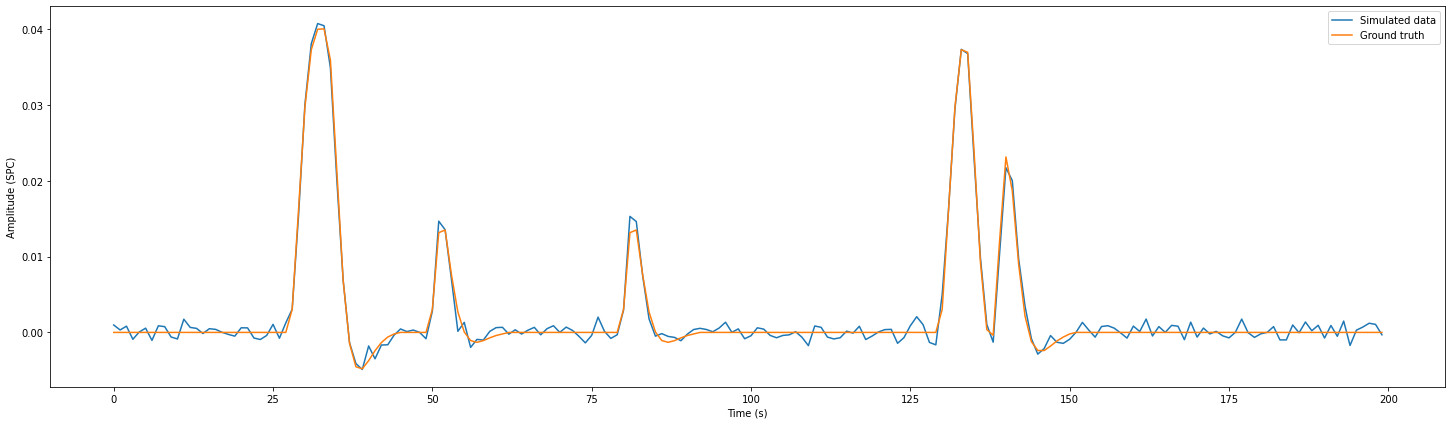

In [3]:
plt.figure(figsize=(25,7))
plt.plot(data[:, 0], label='Simulated data')
plt.plot(ground_truth_bold, label='Ground truth')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (SPC)')
plt.legend()
plt.show()

In [4]:
params = {'tr': 2, 'cost_save': True, 'te': [0]} # This is for TA (to follow MATLAB code structure)
# Generate design matrix (shifted HRFs) for PFM with the spike model
hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

In [5]:
import pylops
from Scripts.hrf_matrix import hrf_linear

p = [6,16,1,1,6,0,32]
hrf_SPM = hrf_linear(params["tr"], p)


hrf = pylops.signalprocessing.Convolve1D(N=nscans, h=hrf_SPM)

In [6]:
data.shape

(200, 1)

In [7]:
xinv, niter = pylops.optimization.sparsity.FISTA(hrf, np.hstack((data, data)), 1000, eps=0.0001, threshkind="hard")

ValueError: operands could not be broadcast together with shapes (200,2) (200,) 

In [ ]:
plt.plot(data)
plt.plot(hrf*xinv)
plt.plot(xinv)

In [ ]:
np.hstack((data, data)).shape

In [ ]:
hrf.matvec(np.hstack((data, data)))